In [2]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [0]:
import torch
import matplotlib.pyplot as plt

# Callbacks

In [0]:
from time import sleep

In [0]:
def slow_calculation():
  res = 0
  for i in range(5):
    res += i*i
    sleep(1)
  return res

In [6]:
slow_calculation()

30

In [0]:
def slow_calculation(cb=None):
    res = 0
    for i in range(5):
        res += i*i
        sleep(1)
        if cb: cb(i)
    return res

In [0]:
def show_progress(epoch):
    print(f"Awesome! We've finished epoch {epoch}!")

In [9]:
slow_calculation(show_progress)

Awesome! We've finished epoch 0!
Awesome! We've finished epoch 1!
Awesome! We've finished epoch 2!
Awesome! We've finished epoch 3!
Awesome! We've finished epoch 4!


30

**Lambdas and partials**

In [10]:
slow_calculation(lambda epoch: print(f"Awesome! We've finished epoch {epoch}!"))

Awesome! We've finished epoch 0!
Awesome! We've finished epoch 1!
Awesome! We've finished epoch 2!
Awesome! We've finished epoch 3!
Awesome! We've finished epoch 4!


30

In [0]:
def show_progress(exclamation, epoch):
  print(f"{exclamation}! We've finished epoch {epoch}!")

In [12]:
slow_calculation(lambda epoch: show_progress("Ok I guess", epoch))

Ok I guess! We've finished epoch 0!
Ok I guess! We've finished epoch 1!
Ok I guess! We've finished epoch 2!
Ok I guess! We've finished epoch 3!
Ok I guess! We've finished epoch 4!


30

In [0]:
#closure
def make_show_progress(exclamation):
    _inner = lambda epoch: print(f"{exclamation}! We've finished epoch {epoch}!")
    return _inner

In [14]:
slow_calculation(make_show_progress("Nice!"))

Nice!! We've finished epoch 0!
Nice!! We've finished epoch 1!
Nice!! We've finished epoch 2!
Nice!! We've finished epoch 3!
Nice!! We've finished epoch 4!


30

In [0]:
def make_show_progress(exclamation):
    # Leading "_" is generally understood to be "private"
    def _inner(epoch): print(f"{exclamation}! We've finished epoch {epoch}!")
    return _inner

In [16]:
slow_calculation(make_show_progress("Nice!"))

Nice!! We've finished epoch 0!
Nice!! We've finished epoch 1!
Nice!! We've finished epoch 2!
Nice!! We've finished epoch 3!
Nice!! We've finished epoch 4!


30

In [0]:
f2 = make_show_progress("Terrific")

In [18]:
slow_calculation(f2)

Terrific! We've finished epoch 0!
Terrific! We've finished epoch 1!
Terrific! We've finished epoch 2!
Terrific! We've finished epoch 3!
Terrific! We've finished epoch 4!


30

In [19]:
from functools import partial

slow_calculation(partial(show_progress, "OK I guess"))

OK I guess! We've finished epoch 0!
OK I guess! We've finished epoch 1!
OK I guess! We've finished epoch 2!
OK I guess! We've finished epoch 3!
OK I guess! We've finished epoch 4!


30

**Multiple callback funcs; args and kwargs**

In [0]:
def f(*args, **kwargs): print(f"args: {args}; kwargs: {kwargs}")

In [21]:
f(3, 'a', thing1="hello")

args: (3, 'a'); kwargs: {'thing1': 'hello'}


In [0]:
def slow_calculation(cb=None):
    res = 0
    for i in range(5):
        if cb: cb.before_calc(i)
        res += i*i
        sleep(1)
        if cb: cb.after_calc(i, val=res)
    return res

In [0]:
class PrintStepCallback():
    def __init__(self): pass
    def before_calc(self, *args, **kwargs): print(f"About to start")
    def after_calc (self, *args, **kwargs): print(f"Done step")

In [24]:
slow_calculation(PrintStepCallback())

About to start
Done step
About to start
Done step
About to start
Done step
About to start
Done step
About to start
Done step


30

In [0]:
class PrintStatusCallback():
    def __init__(self): pass
    def before_calc(self, epoch, **kwargs): print(f"About to start: {epoch}")
    def after_calc (self, epoch, val, **kwargs): print(f"After {epoch}: {val}")

In [26]:
slow_calculation(PrintStatusCallback())

About to start: 0
After 0: 0
About to start: 1
After 1: 1
About to start: 2
After 2: 5
About to start: 3
After 3: 14
About to start: 4
After 4: 30


30

**Modifying behavior**

In [0]:
def slow_calculation(cb=None):
    res = 0
    for i in range(5):
        if cb and hasattr(cb,'before_calc'): cb.before_calc(i)
        res += i*i
        sleep(1)
        if cb and hasattr(cb,'after_calc'):
            if cb.after_calc(i, res):
                print("stopping early")
                break
    return res

In [0]:
class PrintAfterCallback():
    def after_calc (self, epoch, val):
        print(f"After {epoch}: {val}")
        if val>10: return True

In [29]:
slow_calculation(PrintAfterCallback())

After 0: 0
After 1: 1
After 2: 5
After 3: 14
stopping early


14

In [0]:

class SlowCalculator():
    def __init__(self, cb=None): self.cb,self.res = cb,0
    
    def callback(self, cb_name, *args):
        if not self.cb: return
        cb = getattr(self.cb,cb_name, None)
        if cb: return cb(self, *args)

    def calc(self):
        for i in range(5):
            self.callback('before_calc', i)
            self.res += i*i
            sleep(1)
            if self.callback('after_calc', i):
                print("stopping early")
                break

In [0]:
class ModifyingCallback():
    def after_calc (self, calc, epoch):
        print(f"After {epoch}: {calc.res}")
        if calc.res>10: return True
        if calc.res<3: calc.res = calc.res*2

In [0]:
calculator = SlowCalculator(ModifyingCallback())

In [0]:
calculator.calc()
calculator.res

After 0: 0
After 1: 1
After 2: 6
After 3: 15
stopping early


15

# __dunder__ thingies

Anything that looks like __this__ is, in some way, special. Python, or some library, can define some functions that they will call at certain documented times. For instance, when your class is setting up a new object, python will call  __init__. These are defined as part of the python data model.

For instance, if python sees +, then it will call the special method __add__. If you try to display an object in Jupyter (or lots of other places in Python) it will call __repr__.

In [0]:
class SloppyAdder():
    def __init__(self,o): self.o=o
    def __add__(self,b): return SloppyAdder(self.o + b.o + 0.01)
    def __repr__(self): return str(self.o) this will be printed when th object is put in print statement

SyntaxError: ignored

In [0]:
a = SloppyAdder(1)
b = SloppyAdder(2)
a+b

3.01

# Variance and stuff
**Variance**
Variance is the average of how far away each data point is from the mean. E.g.:

In [0]:
t = torch.tensor([1.,2.,4.,18])

In [42]:
m = t.mean(); m

tensor(6.2500)

In [43]:
(t-m).mean()

tensor(0.)

In [44]:
(t-m).pow(2).mean()

tensor(47.1875)

In [45]:
(t-m).abs().mean()

tensor(5.8750)

In [46]:
(t-m).pow(2).mean().sqrt()

tensor(6.8693)



```
(t-m).abs().mean()
```



```
(t-m).pow(2).mean().sqrt()
```



They're still different. Why?

Note that we have one outlier (18). In the version where we square everything, it makes that much bigger than everything else.

(t-m).pow(2).mean() is refered to as variance. It's a measure of how spread out the data is, and is particularly sensitive to outliers.

When we take the sqrt of the variance, we get the standard deviation. Since it's on the same kind of scale as the original data, it's generally more interpretable. However, since sqrt(1)==1, it doesn't much matter which we use when talking about unit variance for initializing neural nets.

(t-m).abs().mean() is referred to as the mean absolute deviation. It isn't used nearly as much as it deserves to be, because mathematicians don't like how awkward it is to work with. But that shouldn't stop us, because we have computers and stuff.

Here's a useful thing to note about variance:

In [47]:
(t-m).pow(2).mean(), (t*t).mean() - (m*m)

(tensor(47.1875), tensor(47.1875))

(tensor(47.1875), tensor(47.1875))
You can see why these are equal if you want to work thru the algebra. Or not.

But, what's important here is that the latter is generally much easier to work with. In particular, you only have to track two things: the sum of the data, and the sum of squares of the data. Whereas in the first form you actually have to go thru all the data twice (once to calculate the mean, once to calculate the differences).

![alt text](https://render.githubusercontent.com/render/math?math=%5Coperatorname%7BE%7D%5Cleft%5BX%5E2%20%5Cright%5D%20-%20%5Coperatorname%7BE%7D%5BX%5D%5E2&mode=display)


**Covariance and correlation**

Here's how Wikipedia defines covariance:

$$\operatorname{cov}(X,Y) = \operatorname{E}{\big[(X - \operatorname{E}[X])(Y - \operatorname{E}[Y])\big]}$$

In [49]:
t

tensor([ 1.,  2.,  4., 18.])

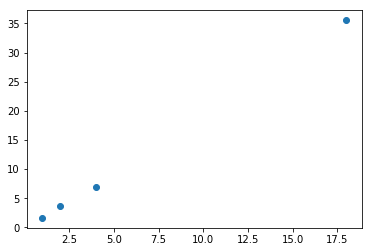

In [50]:
# `u` is twice `t`, plus a bit of randomness
u = t*2
u *= torch.randn_like(t)/10+0.95

plt.scatter(t, u);

In [51]:
prod = (t-t.mean())*(u-u.mean()); prod

tensor([ 54.2585,  34.9876,  11.2106, 276.7102])

In [52]:
prod.mean()

tensor(94.2917)

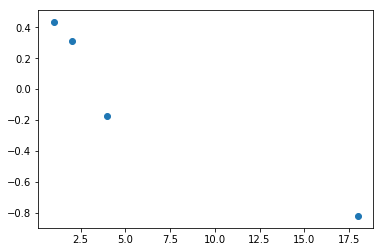

In [53]:
v = torch.randn_like(t)
plt.scatter(t, v);

In [55]:
((t-t.mean())*(v-v.mean())).mean()

tensor(-3.2097)


It's generally more conveniently defined like so:

$$\operatorname{E}\left[X Y\right] - \operatorname{E}\left[X\right] \operatorname{E}\left[Y\right]$$

In [56]:
cov = (t*v).mean() - t.mean()*v.mean(); cov

tensor(-3.2097)


From now on, you're not allowed to look at an equation (or especially type it in LaTeX) without also typing it in Python and actually calculating some values. Ideally, you should also plot some values.

Finally, here is the Pearson correlation coefficient:

$$\rho_{X,Y}= \frac{\operatorname{cov}(X,Y)}{\sigma_X \sigma_Y}$$

In [0]:
cov / (t.std() * v.std())


It's just a scaled version of the same thing. Question: Why is it scaled by standard deviation, and not by variance or mean or something else?